In [133]:
from io import StringIO
from dotenv import load_dotenv, dotenv_values 
import os

import boto3
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import seaborn as sns
load_dotenv() 

pd.set_option("display.max_columns", 50)


In [2]:
aws_access_key_id = os.getenv("AWS_ACCESS_KEY")
aws_secret_key = os.getenv("AWS_SECRET_KEY")

In [3]:
def read_csv_from_s3(bucket: str, path: str, filename: str) -> pd.DataFrame:
    """Downloads a csv file from an S3 bucket
    
    Args:
        bucket (str):
            - The bucket where the files at.
        path (str):
            - The folders to the file.
        filename (str):
            - Name of the file.

    Returns:
        pd.DataFrame:
            - A DataFrame of the downloaded file.
    """
    s3 = boto3.client("s3", aws_access_key_id=aws_access_key_id, aws_secret_access_key= aws_secret_key)
    
    full_path = f"{path}{filename}"
    
    object = s3.get_object(Bucket=bucket, Key=full_path)
    object = object["Body"].read().decode("utf-8")
    output_df = pd.read_csv(StringIO(object))
    
    return output_df

#### Prepare the folders

In [4]:
s3 = boto3.client("s3", aws_access_key_id=aws_access_key_id, aws_secret_access_key= aws_secret_key)
bucket = "cubix-chicago-taxi-sm"

community_areas_path = "transformed_data/community_areas/"
company_path = "transformed_data/company/"
date_path = "transformed_data/date/"
payment_type_path = "transformed_data/payment_type/"
taxi_trips_path = "transformed_data/taxi_trips/"
weather_path = "transformed_data/weather/"


#### Read files

In [5]:
community_areas = read_csv_from_s3(bucket, community_areas_path, "community_areas_master.csv")
company = read_csv_from_s3(bucket, company_path, "company_master.csv")
date = read_csv_from_s3(bucket, date_path, "date_dimension.csv")
payment_type = read_csv_from_s3(bucket=bucket, path=payment_type_path, filename="payment_type_master.csv")

In [6]:
trips_list = []
weather_list = []

In [7]:
for file in s3.list_objects(Bucket=bucket, Prefix=taxi_trips_path)["Contents"]:
    taxi_trip_key = file["Key"]
    
    if taxi_trip_key.split("/")[-1].strip() != "":
        if taxi_trip_key.split(".")[1] == "csv":
            
            filename = taxi_trip_key.split("/")[-1]
            trip = read_csv_from_s3(bucket= bucket, path= taxi_trips_path, filename= filename)

            trips_list.append(trip)
            print(f"{filename} has been added.")
            
            
            

taxi_2024-10-10.csv has been added.
taxi_2024-10-11.csv has been added.
taxi_2024-10-12.csv has been added.
taxi_2024-10-13.csv has been added.
taxi_2024-10-14.csv has been added.
taxi_2024-10-15.csv has been added.
taxi_2024-10-16.csv has been added.
taxi_2024-10-17.csv has been added.
taxi_2024-10-18.csv has been added.
taxi_2024-10-19.csv has been added.
taxi_2024-10-20.csv has been added.
taxi_2024-10-21.csv has been added.
taxi_2024-10-22.csv has been added.


In [8]:
trips = pd.concat(trips_list, ignore_index=True)

In [11]:
trips.shape

(235071, 20)

In [13]:
for file in s3.list_objects(Bucket=bucket, Prefix=weather_path)["Contents"]:
    weather_key = file["Key"]
    
    if weather_key.split("/")[-1].strip() != "":
        if weather_key.split(".")[1] == "csv":
            
            filename = weather_key.split("/")[-1]
            weather_daily = read_csv_from_s3(bucket= bucket, path= weather_path, filename= filename)

            weather_list.append(weather_daily)
            print(f"{filename} has been added.")
            
           

weather_2024-10-10.csv has been added.
weather_2024-10-11.csv has been added.
weather_2024-10-12.csv has been added.
weather_2024-10-13.csv has been added.
weather_2024-10-14.csv has been added.
weather_2024-10-15.csv has been added.
weather_2024-10-16.csv has been added.
weather_2024-10-17.csv has been added.
weather_2024-10-18.csv has been added.
weather_2024-10-19.csv has been added.
weather_2024-10-20.csv has been added.
weather_2024-10-21.csv has been added.
weather_2024-10-22.csv has been added.


In [14]:
weather = pd.concat(weather_list, ignore_index=True)

In [17]:
weather.shape

(312, 5)

#### Join them together

In [90]:
trips_full = pd.merge(trips, weather, left_on="datetime_for_weather", right_on= "datetime", how= "inner")
trips_full = trips_full.drop(columns=["datetime"])

In [91]:
trips_full = pd.merge(trips_full, company, left_on="company_id", right_on="company_id", how="inner")
trips_full = trips_full.drop(columns=["company_id"])

In [92]:
trips_full = pd.merge(trips_full, payment_type, left_on="payment_type_id", right_on="payment_type_id", how="inner")
trips_full = trips_full.drop(columns=["payment_type_id"])

In [93]:
trips_full = pd.merge(trips_full, community_areas, left_on="pickup_community_area_id", right_on="area_code", how="inner")
trips_full = trips_full.drop(columns=["pickup_community_area_id","area_code"])
trips_full.rename(columns={"community_name": "pickup_community_area_name"}, inplace=True)

In [94]:
trips_full = pd.merge(trips_full, community_areas, left_on="dropoff_community_area_id", right_on="area_code", how="inner")
trips_full = trips_full.drop(columns=["dropoff_community_area_id","area_code"])
trips_full.rename(columns={"community_name": "dropoff_community_area_name"}, inplace=True)

In [95]:
date['date'] = pd.to_datetime(date['date'])
trips_full["trip_start_timestamp"] = pd.to_datetime(trips_full["trip_start_timestamp"])

trips_full["trip_start_date"] = trips_full["trip_start_timestamp"].dt.date
trips_full["trip_start_date"] = pd.to_datetime(trips_full["trip_start_date"])

In [96]:
trips_full = pd.merge(trips_full, date, left_on="trip_start_date", right_on="date", how="inner")
trips_full = trips_full.drop(columns=["date"])

In [110]:
trips_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234986 entries, 0 to 234985
Data columns (total 30 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   trip_id                      234986 non-null  object        
 1   taxi_id                      234986 non-null  object        
 2   trip_start_timestamp         234986 non-null  datetime64[ns]
 3   trip_end_timestamp           234986 non-null  object        
 4   trip_seconds                 234986 non-null  int64         
 5   trip_miles                   234986 non-null  float64       
 6   fare                         234986 non-null  float64       
 7   tips                         234986 non-null  float64       
 8   tolls                        234986 non-null  float64       
 9   extras                       234986 non-null  float64       
 10  trip_total                   234986 non-null  float64       
 11  pickup_centroid_latitude  

#### Visualisations

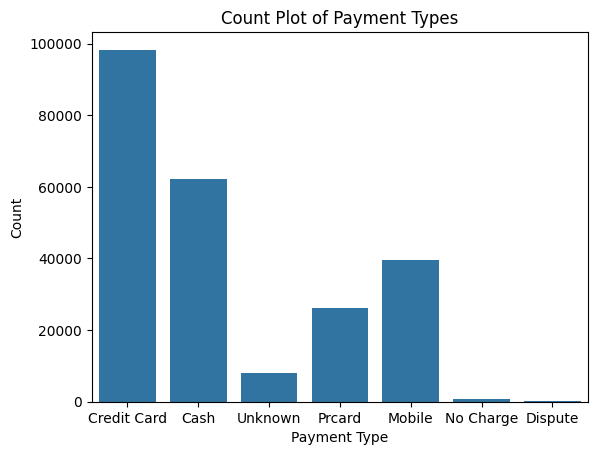

In [102]:
#1. - Count of Payment Types

sns.countplot(x='payment_type', data=trips_full)
plt.title('Count of Payment Types')
plt.xlabel('Payment Type')
plt.ylabel('Count')
plt.show()

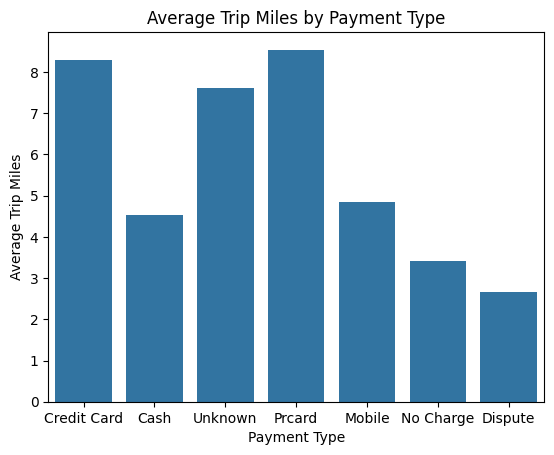

In [154]:
#2. - Average Trip Miles by Payment Type

sns.barplot(x='payment_type', y='trip_miles', data=trips_full, errorbar=None)
plt.title('Average Trip Miles by Payment Type')
plt.xlabel('Payment Type')
plt.ylabel('Average Trip Miles')
plt.show()

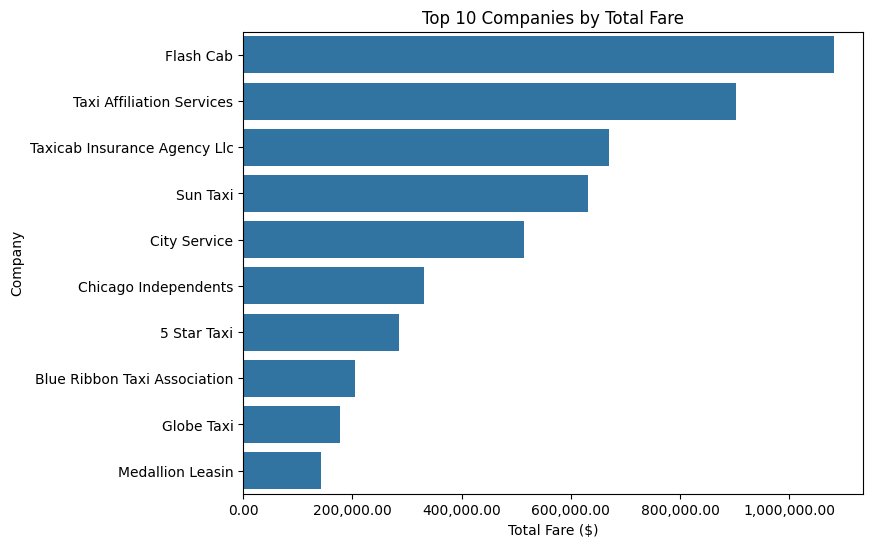

In [146]:
# 3. - Top 10 Companies by Total Fare
companies = (
    trips_full.groupby('company')['fare']
    .sum()
    .round(2)
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(8, 6))
sns.barplot(x=companies.values, y=companies.index, orient='h', errorbar=None)
plt.title('Top 10 Companies by Total Fare')
plt.xlabel('Total Fare ($)')
plt.ylabel('Company') 
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:,.2f}'))
plt.show()

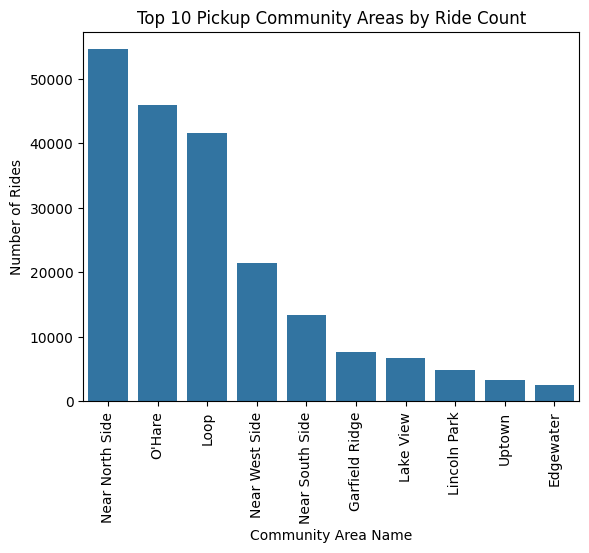

In [142]:
# 4. - Top 10 Pickup Community Areas by Ride Count
top_community_areas = (
    trips_full.groupby('pickup_community_area_name')
    .size()
    .sort_values(ascending=False)
    .head(10)
)

sns.barplot(x=top_community_areas.index, y=top_community_areas.values, errorbar=None)
plt.title('Top 10 Pickup Community Areas by Ride Count')
plt.xlabel('Community Area Name')
plt.ylabel('Number of Rides')
plt.xticks(rotation=90)
plt.show()

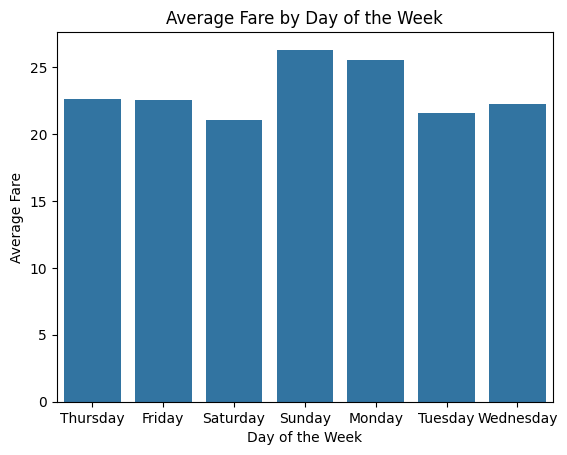

In [104]:
#5. - Average Fare by Day of the Week

trips_full['day_of_week'] = trips_full['trip_start_timestamp'].dt.day_name()
sns.barplot(x='day_of_week', y='fare', data=trips_full, errorbar=None)
plt.title('Average Fare by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Fare')
plt.show()